In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import time
from keras.models import load_model
np.random.seed(21)

Using TensorFlow backend.


In [2]:
# load data with datetime index
mrti_data = pd.read_csv('../data/Maruti/Weekly/data.csv', parse_dates=[0])

# sort by date
mrti_data.sort_values('Date', inplace=True)

# reindex dataframe
mrti_data.set_index(keys=['Date'], drop=True, inplace=True)
print('='*40)

# check for missing values
print(mrti_data.isnull().sum())
print('='*40)

# convert 'Change %' column entries to numbers
mrti_data['Change %'] = mrti_data['Change %'].apply(lambda x:float(x.split('%')[0]))

def convert(row):
    '''Function for converting volume entries to numbers
    Input: row ---> Row entry; for ex: 5.1M, 8.22K
    Output num ---> Volume in numbers; for ex: 5.1M to 5100000  
    '''
    if row[-1] == 'M':
        num = float(row[:-1])*1000000
    elif row[-1] == 'K':
        num = float(row[:-1])*1000
    else:
        num = 0
    return num

# convert 'Vol.' column entries to numbers
mrti_data['Vol.'] = mrti_data['Vol.'].apply(lambda x:convert(x))

mrti_data.head()

Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-07,1455.15,1500.0,1514.0,1444.10,157710.0,-3.86
2010-11-14,1406.20,1461.0,1461.0,1377.00,162220.0,-3.36
2010-11-21,1364.85,1406.0,1467.8,1335.20,198660.0,-2.94
2010-11-28,1399.70,1367.0,1450.0,1364.85,206930.0,2.55
2010-12-05,1411.65,1405.0,1446.0,1368.00,205880.0,0.85


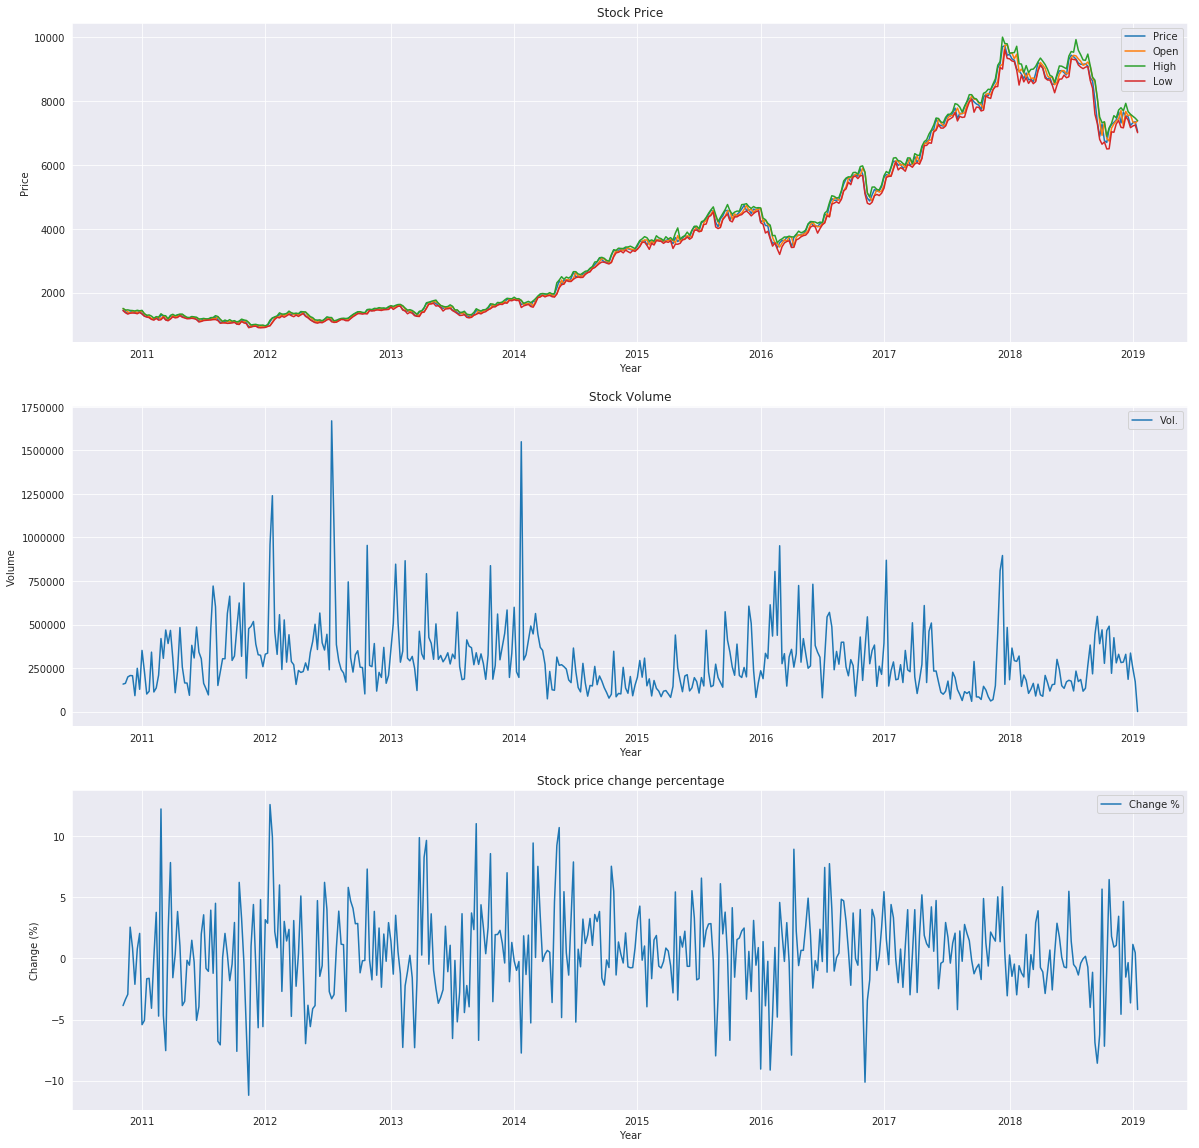

In [3]:
# initialize figure and axes
fig, (ax_1, ax_2, ax_3) = plt.subplots(3,1, figsize=(20,20))

# plot open, close, high and low prices
mrti_data.plot(y=['Price', 'Open', 'High', 'Low'], ax=ax_1)
ax_1.set_title('Stock Price')
ax_1.set_xlabel('Year')
ax_1.set_ylabel('Price')

# plot volume
mrti_data.plot(y='Vol.', ax=ax_2)
ax_2.set_title('Stock Volume')
ax_2.set_xlabel('Year')
ax_2.set_ylabel('Volume')

# plot percentage change
mrti_data.plot(y='Change %', ax=ax_3)
ax_3.set_title('Stock price change percentage')
ax_3.set_xlabel('Year')
ax_3.set_ylabel('Change (%)')

plt.show()

In [4]:
mrti_data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-07,1455.15,1500.0,1514.0,1444.10,157710.0,-3.86
2010-11-14,1406.20,1461.0,1461.0,1377.00,162220.0,-3.36
2010-11-21,1364.85,1406.0,1467.8,1335.20,198660.0,-2.94
2010-11-28,1399.70,1367.0,1450.0,1364.85,206930.0,2.55
2010-12-05,1411.65,1405.0,1446.0,1368.00,205880.0,0.85


In [5]:
mrti_data.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-12-23,7510.70,7542.0,7670.0,7406.00,185220.0,-0.35
2018-12-30,7237.40,7575.0,7586.6,7168.55,335940.0,-3.64
2019-01-06,7319.80,7350.0,7525.0,7220.00,247610.0,1.14
2019-01-13,7353.35,7311.0,7465.0,7251.85,171470.0,0.46
2019-01-20,7046.15,7384.0,7384.0,7011.00,0.0,-4.18


In [7]:
mrti_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 429 entries, 2010-11-07 to 2019-01-20
Data columns (total 6 columns):
Price       429 non-null float64
Open        429 non-null float64
High        429 non-null float64
Low         429 non-null float64
Vol.        429 non-null float64
Change %    429 non-null float64
dtypes: float64(6)
memory usage: 23.5 KB


In [8]:
# split data
train_data = mrti_data.iloc[:360,:]
test_data = mrti_data.iloc[:360,:]

# normalize 
scaler = MinMaxScaler()

# normalize training data
train_data.iloc[:,:] = scaler.fit_transform(train_data)

# normalize test data
test_data.iloc[:,:] = scaler.transform(test_data.iloc[:,:])

# split into train and test features and targets
X_train, y_train = train_data.iloc[:,1:], train_data.iloc[:,0]
X_test, y_test = test_data.iloc[:,1:], test_data.iloc[:,0]

In [9]:
X_train.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2010-11-07,0.080006,0.075434,0.075380,0.061383,0.308502
2010-11-14,0.074617,0.068105,0.065988,0.064182,0.329545
2010-11-21,0.067017,0.069045,0.060138,0.086799,0.347222
2010-11-28,0.061628,0.066584,0.064288,0.091932,0.578283
2010-12-05,0.066879,0.066031,0.064729,0.091280,0.506734


In [10]:
X_test.head()

,Open,High,Low,Vol.,Change %
Date,,,,,
2010-11-07,-0.127252,-0.133918,-0.126738,-0.036501,0.483944
2010-11-14,-0.127252,-0.133919,-0.126739,-0.036501,0.484829
2010-11-21,-0.127253,-0.133918,-0.126740,-0.036501,0.485573
2010-11-28,-0.127254,-0.133919,-0.126740,-0.036501,0.495298
2010-12-05,-0.127253,-0.133919,-0.126740,-0.036501,0.492287


In [11]:
y_train.head()

Date
2010-11-07    0.074650
2010-11-14    0.067821
2010-11-21    0.062052
2010-11-28    0.066914
2010-12-05    0.068581
Name: Price, dtype: float64

In [12]:
y_test.head()

Date
2010-11-07   -0.128342
2010-11-14   -0.128343
2010-11-21   -0.128344
2010-11-28   -0.128343
2010-12-05   -0.128343
Name: Price, dtype: float64

In [13]:
# initialize model with Keras
model = Sequential()

# add 3 LSTM layers with dropout
model.add(LSTM(input_dim=5, output_dim=20, return_sequences=True))
# model.add(Dropout(0.1))

model.add(LSTM(40, return_sequences=True))
# model.add(Dropout(0.1))

model.add(LSTM(10, return_sequences=False))
# model.add(Dropout(0.1))

# add Dense layer with ReLU activation
model.add(Dense(10,activation='sigmoid'))        

# add Dense layer with Linear activation
model.add(Dense(1,activation='linear'))

# start time
start = time.time()

# compile model
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# model compilation time
print ('compilation time : ', time.time() - start)

compilation time :  0.04350590705871582


In [14]:
# Fit model on training data with validation data 5% of training data and 150 epochs
model.fit(X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]),y_train, nb_epoch=10, validation_split=0.05, batch_size=50)

Train on 342 samples, validate on 18 samples
Epoch 1/10
342/342 [==============================] - 3s 10ms/step - loss: 1.2545 - mean_squared_error: 1.2545 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2/10
342/342 [==============================] - 0s 318us/step - loss: 0.4790 - mean_squared_error: 0.4790 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 3/10
342/342 [==============================] - 0s 317us/step - loss: 0.2046 - mean_squared_error: 0.2046 - val_loss: 0.1612 - val_mean_squared_error: 0.1612
Epoch 4/10
342/342 [==============================] - 0s 334us/step - loss: 0.1062 - mean_squared_error: 0.1062 - val_loss: 0.2642 - val_mean_squared_error: 0.2642
Epoch 5/10
342/342 [==============================] - 0s 313us/step - loss: 0.0712 - mean_squared_error: 0.0712 - val_loss: 0.3403 - val_mean_squared_error: 0.3403
Epoch 6/10
342/342 [==============================] - 0s 336us/step - loss: 0.0583 - mean_squared_error: 0.0583 - val_loss: 0.3885 - val

In [15]:
# make predictions
y_pred = model.predict(X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1]))

# create copy of original test data to rescale data into original format
test_predictions = test_data.copy()

# set 'Price' feature value as predicted values
test_predictions[['Price']] = y_pred

# inverse transform predictions data
test_predictions.iloc[:,:] = scaler.inverse_transform(test_predictions)
preds = test_predictions.iloc[:,0]

# inverse transform original test data
test_data.iloc[:,:] = scaler.inverse_transform(test_data)
actual = test_data.iloc[:,0]

In [16]:
preds

Date
2010-11-07    2757.613660
2010-11-14    2757.614087
2010-11-21    2757.614087
2010-11-28    2757.618360
2010-12-05    2757.617078
2010-12-12    2757.614942
2010-12-19    2757.617078
2010-12-26    2757.617933
2011-01-02    2757.612378
2011-01-09    2757.612806
2011-01-16    2757.615369
2011-01-23    2757.615369
2011-01-30    2757.613233
2011-02-06    2757.617078
2011-02-13    2757.619215
2011-02-20    2757.612806
2011-02-27    2757.625196
2011-03-06    2757.613233
2011-03-13    2757.611524
2011-03-20    2757.617933
2011-03-27    2757.622205
2011-04-03    2757.615369
2011-04-10    2757.617078
2011-04-17    2757.618787
2011-04-24    2757.617078
2011-05-01    2757.613660
2011-05-08    2757.613233
2011-05-15    2757.616224
2011-05-22    2757.616224
2011-05-29    2757.617078
                 ...     
2017-03-05    2757.617505
2017-03-12    2757.619642
2017-03-19    2757.614515
2017-03-26    2757.617078
2017-04-02    2757.620069
2017-04-09    2757.614515
2017-04-16    2757.618360
2017-04

In [19]:
test_data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-11-07,0.074650,0.080006,0.075434,0.075380,0.061383,0.308502
2010-11-14,0.067821,0.074617,0.068105,0.065988,0.064182,0.329545
2010-11-21,0.062052,0.067017,0.069045,0.060138,0.086799,0.347222
2010-11-28,0.066914,0.061628,0.066584,0.064288,0.091932,0.578283
2010-12-05,0.068581,0.066879,0.066031,0.064729,0.091280,0.506734


In [ ]:
# calculate mean squared error on test data
error = np.sqrt(mean_squared_error(preds, actual))
print(error)

In [ ]:
# comapre original vs predicted stock prices
plt.figure(figsize=(20,10))
plt.plot(actual, color='green')
plt.plot(preds, color='black')
plt.legend(['Actual Price', 'Predicted Price'])
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted vs Actual Stock Price')
plt.show()